<a href="https://colab.research.google.com/github/Nicole-Perrotta/AILabProj-Live_ASL_Classification/blob/main/Live_ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training of the dataset with fine tuning 

**Enabling and testing the GPU**

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Importing libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive

**Mounting the drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Processing the data**

In [ ]:
!unzip '/content/drive/MyDrive/dataset.zip' 

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/Y/Y190.jpg      
  inflating: dataset/Y/Y1900.jpg     
  inflating: dataset/Y/Y1901.jpg     
  inflating: dataset/Y/Y1902.jpg     
  inflating: dataset/Y/Y1903.jpg     
  inflating: dataset/Y/Y1904.jpg     
  inflating: dataset/Y/Y1905.jpg     
  inflating: dataset/Y/Y1906.jpg     
  inflating: dataset/Y/Y1907.jpg     
  inflating: dataset/Y/Y1908.jpg     
  inflating: dataset/Y/Y1909.jpg     
  inflating: dataset/Y/Y191.jpg      
  inflating: dataset/Y/Y1910.jpg     
  inflating: dataset/Y/Y1911.jpg     
  inflating: dataset/Y/Y1912.jpg     
  inflating: dataset/Y/Y1913.jpg     
  inflating: dataset/Y/Y1914.jpg     
  inflating: dataset/Y/Y1915.jpg     
  inflating: dataset/Y/Y1916.jpg     
  inflating: dataset/Y/Y1917.jpg     
  inflating: dataset/Y/Y1918.jpg     
  inflating: dataset/Y/Y1919.jpg     
  inflating: dataset/Y/Y192.jpg      
  inflating: dataset/Y/Y1920.jpg     
  inflating: dataset/Y/Y1921.jpg     


In [ ]:
data_dir = '/content/dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

87000


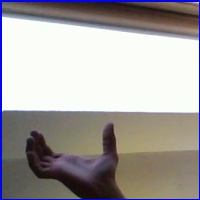

In [ ]:
A_letter = list(data_dir.glob('space/*'))
PIL.Image.open(str(A_letter[0]))

**Creating the dataset**

In [ ]:
batch_size = 8 # tried with 8, 16, 32
img_height = 75 # tried with 64, 32, 128
img_width = 75 # tried with 64

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode="categorical",  #so the labels are not ordered integers, but tensors
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode="categorical",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


**Creating a test set from validation dataset**

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 1740
Number of test batches: 435


**Displaying the names of the classes**

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


**Data visualisation**

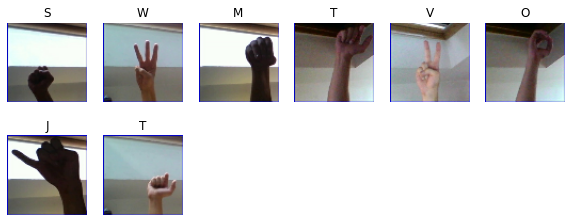

In [ ]:
#case 0: labels as integers
"""
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
"""

#case 1: labels as tensors
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.math.argmax(labels[i])])
    plt.axis("off")

**Checking the image_batch shape of default data 200x200x3(channels)**

In [ ]:
for image_batch, class_names in train_ds: 
  print(image_batch.shape)
  print(class_names)
  break

(8, 75, 75, 3)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]], shape=(8, 29), dtype=float32)


**Buffered prefetching**

It is useful because you can yield data from disk without having I/O become blocking.

These are two important methods you should use when loading data:

`Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Data augmentation**

Consists of a set of data manipulation and transformation techniques that aim to expand the size of the starting dataset, in order to guarantee the feasibility of Machine Learning and Advanced Analytics projects even in situations where there is no the possibility of collecting new data to reach the minimum amount of information necessary to start projects.

In [ ]:
#case 0: Flip and Rotation
"""
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), #images turn specularly randomly
  tf.keras.layers.RandomRotation(0.2),
"""

#case 1: Flip, Rotation, Crop, Contrast and Zoom
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(factor=(-0.2, 0.3),fill_mode="reflect"),
  tf.keras.layers.RandomCrop(img_height, img_width),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(0.2)])

**Creating the base model**

In [ ]:
"""ResNet50V2
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',)
"""
""""MobileNetV2
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',)
"""
""""MobileNet
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',)
"""
""""EfficientNet
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling=None,)
InceptionV3"""
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling=None,)

base_model.trainable = False #freezing the weights
base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

**Creating the global_average_layer and the prediction_layer**

In [ ]:
with tf.device('/gpu:0'):
  image_batch, label_batch = next(iter(train_ds))
  feature_batch = base_model(image_batch)
  print(label_batch.shape)
  print(feature_batch.shape)

(8, 29)
(8, 1, 1, 2048)


Global average pooling

This layer allows to reduce the complexity of the CNN considering only a part of the data. The goal of pooling is to minimize complexity, thus reducing overfitting.

There are two pooling techniques: max pooling and average pooling.

Operations are carried out to calculate the maximum or average value on a subset of boxes of the input matrix.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


Dense layer

They create interconnections between the various layers of the network. Each neuron is connected to every other neuron of the next layer, which means that its output value becomes the input for the next neurons.


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 29)


**Modifying pre-processing according to the used network**

In [ ]:
"""
ResnNet50V2
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
MobileNet
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
EfficientNetB0
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
InceptionV3"""
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

**Finishing the construction of the model**

The network is built by adding the previously written layers and a Dropout layer to the base_model.

The Dropout technique involves first removing a certain percentage of neurons in each hidden layer and for each training period, one randomly chooses which neurons to keep and discard and trains the resulting network. The procedure is then repeated, keeping and discarding different neurons at each epoch: once the network is believed to be ready, the original network is taken and the weights coming out of the hidden neurons are adjusted. The goal of dropout is reducing overfitting.

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x) #pooling
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs)
model = tf.keras.Model(inputs, outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 29), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


**Displaying the structure of the model**

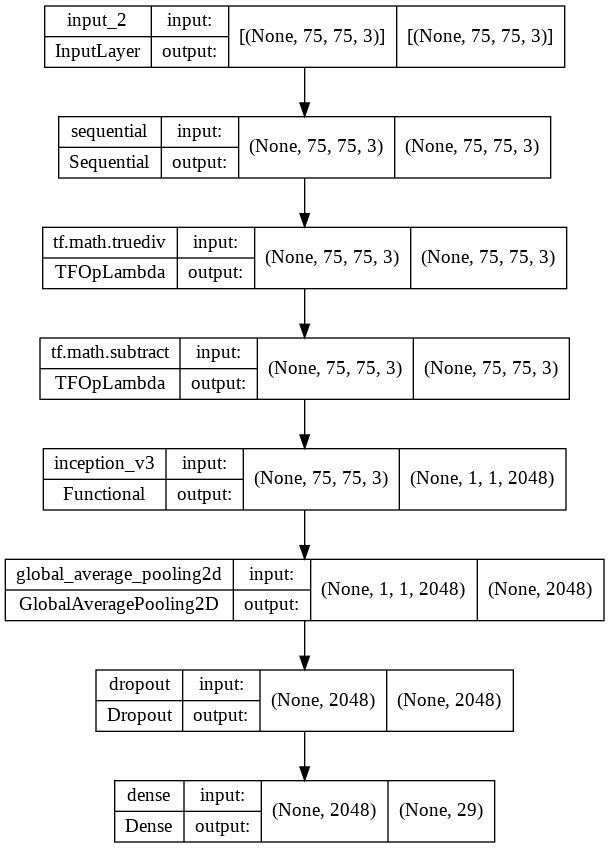

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

**Early stopping**

It halts the training of the network at the right time

In [ ]:
early_stop = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=10,
        verbose=1
    )
]

**Training of the model**

In [ ]:
def adapt_learning_rate(epoch):
    return 0.001 * (epoch + 1)

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)


In [ ]:
import time
start = time.time()
with tf.device('/gpu:0'):
    history = model.fit(
        train_ds, 
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stop,lr_scheduler],
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/20
8700/8700 [==============================] - 252s 28ms/step - loss: 2.3600 - accuracy: 0.3679 - val_loss: 1.7494 - val_accuracy: 0.5098 - lr: 0.0010
Epoch 2/20
8700/8700 [==============================] - 178s 20ms/step - loss: 2.9123 - accuracy: 0.3748 - val_loss: 2.3501 - val_accuracy: 0.4654 - lr: 0.0020
Epoch 3/20
8700/8700 [==============================] - 176s 20ms/step - loss: 3.8109 - accuracy: 0.3655 - val_loss: 2.6795 - val_accuracy: 0.4774 - lr: 0.0030
Epoch 4/20
8700/8700 [==============================] - 177s 20ms/step - loss: 4.8731 - accuracy: 0.3625 - val_loss: 3.7273 - val_accuracy: 0.4523 - lr: 0.0040
Epoch 5/20
8700/8700 [==============================] - 179s 21ms/step - loss: 6.0322 - accuracy: 0.3581 - val_loss: 4.4653 - val_accuracy: 0.4425 - lr: 0.0050
Epoch 6/20
8700/8700 [==============================] - 179s 21ms/step - loss: 7.2441 - accuracy: 0.3621 - val_loss: 5.2274 - val_accuracy: 0.4504 - lr: 0.0060
Epoch 7/20
8700/8700 [==================

**Learning curves of the training and validation accuracy/loss**



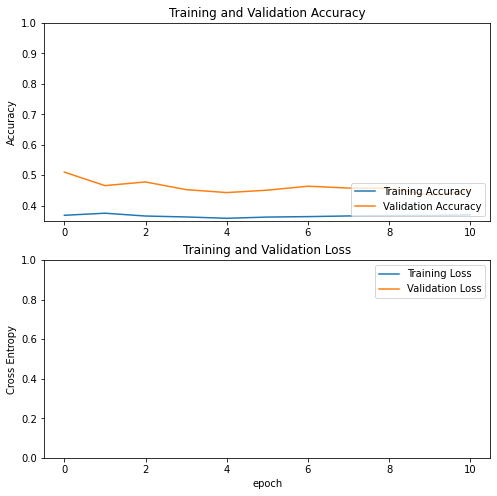

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Finetuning with layer training**


One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning and speed-up the training.


In [ ]:
base_model.trainable = True

Unfreeze the base_model and set the bottom layers to be un-trainable. Then, recompile the model and resume training.

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100 

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


Recompile and re-train the model, this step will improve your accuracy by some percentage points.

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

130

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


start = time.time()
with tf.device('/gpu:0'):
  history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 11/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8700/8700 [==============================] - 319s 36ms/step - loss: 1.2952 - accuracy: 0.6167 - val_loss: 0.5533 - val_accuracy: 0.8314
Epoch 12/20
8700/8700 [==============================] - 309s 35ms/step - loss: 0.5091 - accuracy: 0.8457 - val_loss: 0.3060 - val_accuracy: 0.8990
Epoch 13/20
8700/8700 [==============================] - 308s 35ms/step - loss: 0.3653 - accuracy: 0.8899 - val_loss: 0.2497 - val_accuracy: 0.9231
Epoch 14/20
8700/8700 [==============================] - 313s 36ms/step - loss: 0.3077 - accuracy: 0.9105 - val_loss: 0.2219 - val_accuracy: 0.9328
Epoch 15/20
8700/8700 [==============================] - 311s 36ms/step - loss: 0.2615 - accuracy: 0.9227 - val_loss: 0.1385 - val_accuracy: 0.9542
Epoch 16/20
8700/8700 [==============================] - 318s 37ms/step - loss: 0.2391 - accuracy: 0.9306 - val_loss: 0.1448 - val_accuracy: 0.9575
Epoch 17/20
8700/8700 [==============================] - 319s 37ms/step - loss: 0.2127 - accuracy: 0.9378 - val_loss: 0.1143

**Finetuning curves and accuracy**

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

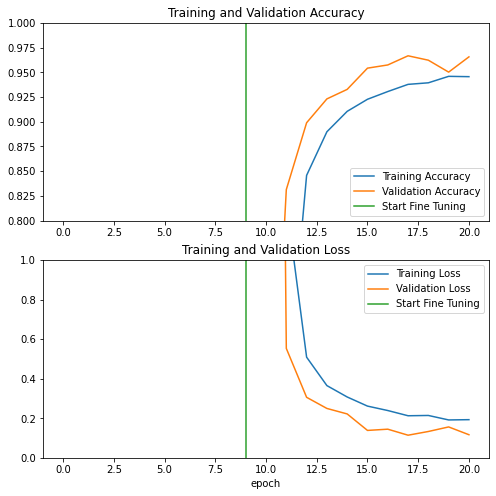

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Evaluation of the model with the test dataset**

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

435/435 [==============================] - 10s 23ms/step - loss: 0.0877 - accuracy: 0.9713
Test accuracy : 0.9712643623352051


**Saving and downloading the model**

In [ ]:
model.save("model_8_75InceptionV3_2")

In [ ]:
!zip -r model_8_75InceptionV3_2.zip /content/model_8_75InceptionV3_2
from google.colab import files
files.download("/content/model_8_75InceptionV3_2.zip")

  adding: content/model_8_75InceptionV3_2/ (stored 0%)
  adding: content/model_8_75InceptionV3_2/variables/ (stored 0%)
  adding: content/model_8_75InceptionV3_2/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: content/model_8_75InceptionV3_2/variables/variables.index (deflated 79%)
  adding: content/model_8_75InceptionV3_2/keras_metadata.pb (deflated 96%)
  adding: content/model_8_75InceptionV3_2/saved_model.pb (deflated 91%)
  adding: content/model_8_75InceptionV3_2/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading and checking the model**

In [ ]:
!unzip '/content/model_8_75InceptionV3_2.zip' 

Archive:  /content/model_8_75InceptionV3_2.zip
   creating: content/model_8_75InceptionV3_2/
   creating: content/model_8_75InceptionV3_2/variables/
  inflating: content/model_8_75InceptionV3_2/variables/variables.data-00000-of-00001  
  inflating: content/model_8_75InceptionV3_2/variables/variables.index  
  inflating: content/model_8_75InceptionV3_2/keras_metadata.pb  
  inflating: content/model_8_75InceptionV3_2/saved_model.pb  
   creating: content/model_8_75InceptionV3_2/assets/


In [ ]:
loaded_model = tf.keras.models.load_model("model_8_75InceptionV3_2")
loss, accuracy = loaded_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


435/435 [==============================] - 12s 23ms/step - loss: 0.0881 - accuracy: 0.9713
Test accuracy : 0.9712643623352051


**Prediction of the hand sign language on some images of the test dataset**







[[6.2849710e-23 3.0141321e-33 8.1055695e-09 3.5023689e-25 2.0672267e-22
  1.2975125e-14 5.3249372e-16 1.1603307e-14 6.4244808e-21 6.0218341e-21
  7.1971322e-22 2.3409725e-16 3.6230120e-34 1.3107608e-21 2.5463718e-15
  3.7238318e-10 1.0000000e+00 7.4402100e-26 1.9758189e-18 4.2098137e-18
  1.6818513e-27 3.3131981e-23 2.1513646e-29 2.1292881e-21 3.6957458e-15
  6.1841618e-14 8.8485586e-10 2.6274054e-28 1.7574256e-12]]


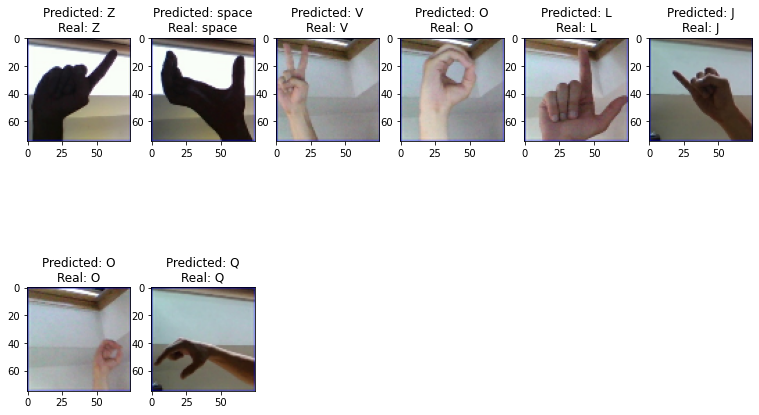

In [ ]:
print("\n")
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(8): #it was 30
    ax = plt.subplot(3, 6, i + 1)
    img = images[i].numpy().astype("uint8")
    
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

   
    plt.title("Predicted: " + class_names[np.argmax(score)] + "\n" + "Real: " + class_names[np.argmax(labels[i])])
    plt.imshow(img)
  print("\n")
  print(predictions)